In [10]:
import alpaca_trade_api as tradeapi
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import *
import time
import seaborn as sns
from sklearn.model_selection import train_test_split

# LTSM
Let's build an LTSM to make overnight predictions on the stock market.
The premise is simple, we will the stocks we predict to do the best during the trading day.
This will be built with the intention of trading on a second by second basis but can easily be modified to a monthly basis.

First lets get a basic handle on what we want and where were going
We'll keep a list of work to do in the section below:

In [4]:
data = np.array([(1553111040,  188.33000183)])

In [8]:
data[0][1]

188.33000183

In [7]:
np.around(data[0][1], decimals=2)

188.33

##### TODO:

- [x] Load in and explore data
- [x] Build batch handling method for input feed
- [x] Scale data
- [x] Build simple neural net to test I/O
- [x] Implement Gird Search CV for more advanced Neural Net development
- [ ] Implement Buy/Sell logic
- [ ] Create a Btest method
- [ ] Hook up to API for easy integration into tarding applications

# Data
First let's get our hands on some data and start exploring it. 
Luckily for us stock market data is very easy to obtain through API calls via alot of services.
For this example we'll be using Alpaca Trade Api which integrates polygon.io for data information.

Lets get some data from an example call:

In [124]:
base_url = 'https://paper-api.alpaca.markets'
api_key_id = 'PKG973MS91PIK8OQ6EF9'
api_secret = 'yRwlo7QSs/DnAUdjcFTIjNgirnbFl09ARoINXKDR'

api = tradeapi.REST(
    base_url=base_url,
    key_id=api_key_id,
    secret_key=api_secret
)
account = api.get_account()
print("Status: ", account.status)
print("Cash: $", account.cash)
print('Clock: ', api.get_clock())

Status:  ACTIVE
Cash: $ 41256.41
Clock:  Clock({   'is_open': False,
    'next_close': '2019-03-25T16:00:00-04:00',
    'next_open': '2019-03-25T09:30:00-04:00',
    'timestamp': '2019-03-24T20:40:33.381577414-04:00'})


In [125]:
print(help(api))

Help on REST in module alpaca_trade_api.rest object:

class REST(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, key_id=None, secret_key=None, base_url=None, api_version=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cancel_order(self, order_id)
 |      Cancel an order
 |  
 |  data_get(self, path, data=None)
 |  
 |  delete(self, path, data=None)
 |  
 |  get(self, path, data=None)
 |  
 |  get_account(self)
 |      Get the account
 |  
 |  get_asset(self, symbol)
 |      Get an asset
 |  
 |  get_barset(self, symbols, timeframe, limit=None, start=None, end=None, after=None, until=None)
 |      Get BarSet(dict[str]->list[Bar])
 |      The parameter symbols can be either a comma-split string
 |      or a list of string. Each symbol becomes the key of
 |      the returned value.
 |  
 |  get_calendar(self, start=None, end=None)
 |  
 |  get_clock(self)
 |  
 |  get_order(self, order_id)
 |      Get an order
 |  
 |  get_order_by_

In [7]:
data = pd.read_csv('../data/quotes.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315 entries, 0 to 314
Data columns (total 15 columns):
time          315 non-null int64
open          315 non-null float64
high          315 non-null float64
low           315 non-null float64
close         315 non-null float64
vol           315 non-null int64
%             315 non-null object
id            315 non-null int64
timestamp     315 non-null object
Vol (20)      315 non-null int64
Vol (20).1    315 non-null object
MACD          315 non-null object
MACD.1        315 non-null int64
MACD.2        315 non-null object
MACD.3        315 non-null object
dtypes: float64(4), int64(5), object(6)
memory usage: 37.0+ KB


In [43]:
api.list_positions()[0]

Position({   'asset_class': 'us_equity',
    'asset_id': 'eedc192c-4d9a-486b-b7d8-38184cb3e840',
    'avg_entry_price': '6.4',
    'change_today': '-0.0074074074074074',
    'cost_basis': '2131.2',
    'current_price': '6.7',
    'exchange': 'NASDAQ',
    'lastday_price': '6.75',
    'market_value': '2231.1',
    'qty': '333',
    'side': 'long',
    'symbol': 'YGYI',
    'unrealized_intraday_pl': '-16.65',
    'unrealized_intraday_plpc': '-0.0074074074074074',
    'unrealized_pl': '99.9',
    'unrealized_plpc': '0.046875'})

In [25]:
api.get_account()

Account({   'account_blocked': False,
    'buying_power': '57716.74',
    'cash': '57716.74',
    'cash_withdrawable': '0',
    'created_at': '2019-03-12T20:33:24.881467Z',
    'currency': 'USD',
    'id': 'adf88c82-78f3-48f9-b15e-97739f05984a',
    'pattern_day_trader': False,
    'portfolio_value': '101275.88',
    'status': 'ACTIVE',
    'trade_suspended_by_user': False,
    'trading_blocked': False,
    'transfers_blocked': False})

In [19]:
api.list_assets()[0].exchange
api.list_assets()[0].symbol


'PDSB'

In [11]:
[item.exchange + ':' + item.symbol for item in api.list_positions()]

['NYSE:TRK',
 'NASDAQ:TEDU',
 'NASDAQ:SNDX',
 'NASDAQ:SMTX',
 'NASDAQ:RMNI',
 'NYSE:QES',
 'NASDAQ:NHTC',
 'AMEX:NES',
 'NYSE:MPX',
 'AMEX:MHH',
 'NASDAQ:LONE',
 'AMEX:LGL',
 'NASDAQ:KEQU',
 'NASDAQ:JVA',
 'NYSE:IRS',
 'NASDAQ:INWK',
 'NASDAQ:INBK',
 'NASDAQ:IDSY',
 'NASDAQ:ICAD',
 'NASDAQ:FRTA',
 'NASDAQ:FARM',
 'NYSE:EVC',
 'NASDAQ:EMKR',
 'NASDAQ:DWSN',
 'NASDAQ:CHFS',
 'NASDAQ:CEMI',
 'NASDAQ:BSET',
 'NASDAQ:BRID',
 'NASDAQ:AVNW',
 'NASDAQ:ASTC',
 'NASDAQ:AGFS',
 'NASDAQ:ADAP']

In [31]:
import os
os.environ["APCA_API_BASE_URL"] = "https://paper-api.alpaca.markets"
os.environ["APCA_API_KEY_ID"] = "PKG973MS91PIK8OQ6EF9"
os.environ["APCA_API_SECRET_KEY"] = "yRwlo7QSs/DnAUdjcFTIjNgirnbFl09ARoINXKDR"
print ('Base url: ', os.environ["APCA_API_BASE_URL"] )
print ('key:', os.environ["APCA_API_KEY_ID"] )
print ('secret:', os.environ["APCA_API_SECRET_KEY"] )
api = tradeapi.REST()

Base url:  https://paper-api.alpaca.markets
key: PKG973MS91PIK8OQ6EF9
secret: yRwlo7QSs/DnAUdjcFTIjNgirnbFl09ARoINXKDR


In [42]:
api.get_barset('AAPL', 'minute', limit=100, start=pd.Timestamp('2019-3-20 09:30',tz='America/New_York').isoformat())

{'AAPL': [Bar({'c': 188.32, 'h': 188.4, 'l': 188.24, 'o': 188.34, 't': 1553105760, 'v': 975}),
  Bar({'c': 188.22, 'h': 188.44, 'l': 188.22, 'o': 188.36, 't': 1553105820, 'v': 1800}),
  Bar({'c': 188.17, 'h': 188.3, 'l': 188.16, 'o': 188.3, 't': 1553105880, 'v': 681}),
  Bar({'c': 188.29, 'h': 188.32, 'l': 188.26, 'o': 188.275, 't': 1553105940, 'v': 755}),
  Bar({'c': 188.42, 'h': 188.45, 'l': 188.29, 'o': 188.29, 't': 1553106000, 'v': 2292}),
  Bar({'c': 188.46, 'h': 188.46, 'l': 188.26, 'o': 188.45, 't': 1553106060, 'v': 1200}),
  Bar({'c': 188.45, 'h': 188.6, 'l': 188.43, 'o': 188.5, 't': 1553106120, 'v': 2611}),
  Bar({'c': 188.57, 'h': 188.59, 'l': 188.47, 'o': 188.47, 't': 1553106180, 'v': 1442}),
  Bar({'c': 188.66, 'h': 188.66, 'l': 188.52, 'o': 188.6, 't': 1553106240, 'v': 1442}),
  Bar({'c': 188.71, 'h': 188.74, 'l': 188.64, 'o': 188.67, 't': 1553106300, 'v': 2791}),
  Bar({'c': 188.9, 'h': 188.91, 'l': 188.8, 'o': 188.8, 't': 1553106360, 'v': 3261}),
  Bar({'c': 188.92, 'h':

In [29]:
api.get_clock()

Clock({   'is_open': False,
    'next_close': '2019-03-21T16:00:00-04:00',
    'next_open': '2019-03-21T09:30:00-04:00',
    'timestamp': '2019-03-20T21:31:19.633781621-04:00'})

Great looks like the api is working!

Now lets make a an api call to polygon to get our data. 
arguments are : `(<size>, <symbol>, <_from>,<start_date>, <offset>, <limit>)`
Lets look at a simple lot of the APPL day prices for the past 1000 days. This will date back to 2015 as of writing this

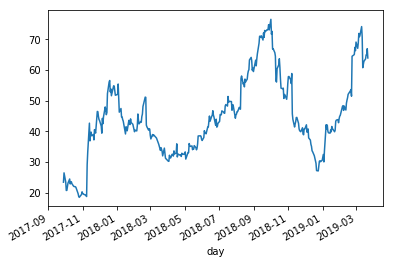

In [130]:
df = api.polygon.historic_agg( _from ='2010-01-01 00:00:00-04:00', size="day" ,symbol='ROKU', limit=None).df
df['close'].plot()

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 372 entries, 2017-09-28 00:00:00-04:00 to 2019-03-22 00:00:00-04:00
Data columns (total 5 columns):
open      372 non-null float64
high      372 non-null float64
low       372 non-null float64
close     372 non-null float64
volume    372 non-null int64
dtypes: float64(4), int64(1)
memory usage: 17.4 KB


In [120]:
df.size

25000

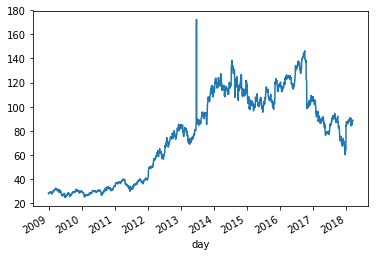

In [68]:
df.drop(columns=['volume']).mean(axis=1).plot()

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2318 entries, 2009-12-31 00:00:00-05:00 to 2019-03-19 00:00:00-04:00
Data columns (total 5 columns):
open      2318 non-null float64
high      2318 non-null float64
low       2318 non-null float64
close     2318 non-null float64
volume    2318 non-null int64
dtypes: float64(4), int64(1)
memory usage: 108.7 KB


In [54]:
normalized_df=(df-df.mean())/df.std()
df = normalized_df
normalized_df.head()

,open,high,low,close,volume
day,,,,,
2009-12-31 00:00:00-05:00,-1.325586,-1.334683,-1.328454,-1.337857,-0.856124
2010-01-04 00:00:00-05:00,-1.324336,-1.334133,-1.332675,-1.337023,-0.331478
2010-01-05 00:00:00-05:00,-1.340037,-1.346636,-1.343002,-1.346058,0.139986
2010-01-06 00:00:00-05:00,-1.341565,-1.329736,-1.331831,-1.327988,0.533919
2010-01-07 00:00:00-05:00,-1.331700,-1.332759,-1.326766,-1.334938,-0.288911


Looks like we'll be working with time series data consisting of the open, high, low, close and current volume at that timestamp. 
Here is where we will be making an important decision. What is it that we want to predict?
Our LTSM will intake a variable and try to predict what it will be at the following timestamp. This means we cant feed in and open price and hope to predict a close price later, we would be able to predict an open price later which can infer the previous close though. One inference we cant make from prediction based off a timestamp, when training on open, is high or low. This is an aggregate from the previous time stamps values along with the fluxuations of the market. For this reason we will stick to trying to predict the close and later the volume. 

First we will build a `fetch_batch(n_batches, batchsize)` method to feed information into our neural network.
It will create batches of a set time series size to be fed into the neural network. 
It will perform random selection with replacement when grabbing a time series from the data set.

In [55]:
def fetch_batch(n_batches, batch_size, prediction_value='close'):
    X_batch = []
    y_batch = []
    for _ in range(n_batches):
        p = np.random.randint(len(df)-batch_size-1, size = 1)[0]

        X_batch.append([[item] for item in df.iloc[p:batch_size+p][prediction_value]])
        #Here we will append the X+1 value for each value X
        y_batch.append([[item] for item in df.iloc[p+1:batch_size+p+1][prediction_value]])
    return np.array(X_batch), np.array(y_batch)
X_batch, y_batch = fetch_batch(5,20)

We can see below that our fetch batch is workign properly. We can see that the X_batch contains items that are at point `i` in the array while items in y_batch are from position `i+1`.

In [ ]:
np.c_[X_batch[0], y_batch[0]]

In [ ]:
X_batch[0][0]

Now that we have the basic data structure intact we will start feeding the data into our neural network. To save time I will hook up an existing LTSM network I used for text analysis to take in time-series-data fo stock values.

# Neural Network
Let's start building the neural network. We know that it will take in a time series batch that is similar to the text analysis script I have in my Machine Learning repository. We will modify this network to take in the fetch_batch we developed.
We may need to tweak error calssifying and gradient boosting values along the way for this type of classification. 

In [ ]:
he_init = tf.keras.initializers.glorot_uniform(seed=None)
tf.reset_default_graph()
n_neurons = 100
n_layers = 3
n_steps = 20

n_inputs = 1
n_outputs = 1
learning_rate = 0.001

        
with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, [None, None, n_inputs])
    y = tf.placeholder(tf.float32, [None, None, n_outputs])

with tf.name_scope('cells'):
    cells = [tf.nn.rnn_cell.LSTMCell(num_units=n_neurons, activation=tf.nn.leaky_relu) for _ in range(n_layers)]
    multi_cell = tf.contrib.rnn.MultiRNNCell(cells)
    output, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32)
            
with tf.name_scope('outputs'):
    outputs = tf.layers.dense(output, n_outputs,
                                name='dense', activation = tf.nn.leaky_relu, 
                                kernel_initializer = he_init)
with tf.name_scope('training'):
    loss = tf.reduce_mean(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)
            
print('Graph Shape')
print('X:', X.shape)
print('y:', y.shape)
print('LSTM states:', states[-1][1].shape)
print('LSTM output:', output.shape)
print('outputs:', outputs.shape)

In [ ]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()
n_epochs = 10000
n_batches = 10
batch_size = 20


mse_summary = tf.summary.scalar('mse', loss)
mse_valid_summary = tf.summary.scalar('mse_valid', loss)
predicted_value = tf.summary.scalar('predicted_value', outputs)
actual_value = tf.summary.scalar('actual_value', X)
root_logdir = 'C:/Users/Kyle/tf_logs/my_logs/'
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
logdir = "{}/run-{}/".format(root_logdir, now)
file_write = tf.summary.FileWriter(logdir, tf.get_default_graph())
training_graphs = []

with tf.Session() as sess:
    init.run()
    print('running')
    for epoch in range(n_epochs):
        X_batch, y_batch = fetch_batch(n_batches, batch_size)
        X_valid, y_valid = fetch_batch(n_batches, batch_size)
        sess.run(train_op, feed_dict = {X: X_batch, y:y_batch})
                
        if epoch %1000 == 0:
            print('\n epoch:',epoch)
            print('MSE train:', loss.eval(feed_dict={X:X_batch, y:y_batch}))
            print('MSE validate: ', loss.eval(feed_dict={X:X_valid, y:y_valid}))
            file_path_2 = "./my_model.ckpt"
            save_path = saver.save(sess, file_path_2)

        if epoch %10 == 0:
            summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
            summary_str2 = mse_valid_summary.eval(feed_dict={X: X_batch, y: y_batch})
            step = epoch
            file_write.add_summary(summary_str, step)   
            file_write.add_summary(summary_str2, step)
        if epoch % 500 ==0:
            y_pred = outputs.eval(feed_dict={X:X_valid})
            training_graphs.append(pd.DataFrame( [X_valid[0].ravel(), y_pred[0].ravel()]).T.rename(columns={0:'Actual', 1:'Predicted'}))
            
            

    

In [ ]:
for graph in training_graphs:
    display(graph.plot())

In [ ]:
X_start = [[1.03],[1.04]]
with tf.Session() as sess:
    saver.restore(sess, "./my_model.ckpt")
    for _ in range(0, 10):
        y_pred = sess.run(outputs, feed_dict = {X:[np.array(X_start)]})
        print(y_pred[0])
        print(X_start)

        X_start.append(y_pred[0][_])
        print(X_start)
        

In [ ]:
X_start

Lets take a look and evaluate our model's performance.
To do this we will resume the session and evalute how well our model is predicting.
We know our MSE is reducing but is the output following the trend of the stock?
Lets take a look at the slope of our predicted output compared to our actual output.

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model.ckpt")
    X_new , _ = fetch_batch(n_batches, batch_size)
    y_pred = sess.run(outputs, feed_dict = {X:X_new})
new_df = pd.DataFrame( [X_new[0].ravel(), y_pred[0].ravel()]).T.rename(columns={0:'Actual', 1:'Predicted'})
new_df.plot()

In [ ]:
for i in new_df.columns:
    plt.scatter(new_df.index, new_df[i], label=i)
    plt.legend(['actual','predicted'])
for j in range(0, len(new_df[i]), 3):
    plt.plot(np.polyval(np.polyfit(new_df.index[0:j+2], new_df['Actual'][0:j+2], 1), new_df.index[0:j+2]), color = 'blue', label = 'actual')
for j in range(0, len(new_df[i]), 3):
    plt.plot(np.polyval(np.polyfit(new_df.index[0:j+2], new_df['Predicted'][0:j+2], 1), new_df.index[0:j+2]), color='orange', label = 'predicted')  

Here we can see that our model is following trend but not predicting trend very well. 
Our metric for improvement is how close our model can get to predicting trend vs how accurate can our model get. 
Now lets make a girdsearcher to find the best model based upon gird search values. But first lets take a look at some interesting tensorflow output.
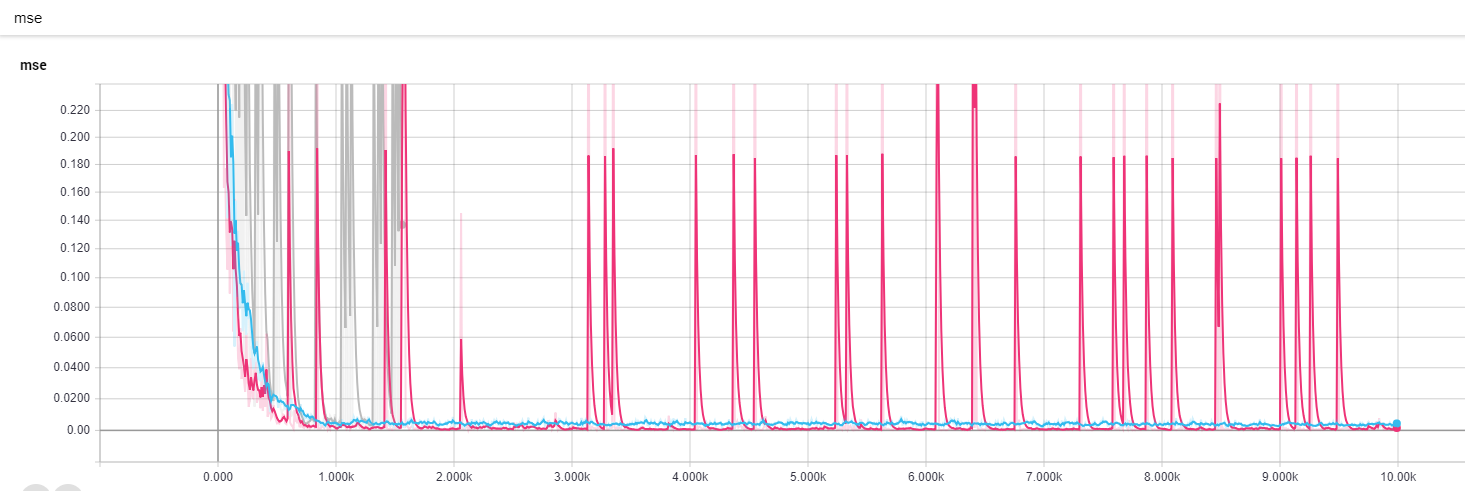

What do we see here? Well first off we can note the obvious in the lare spikes that appear periodically. We can also make note that our later run, the  pink line, had a better mse after applying a Standard Scalar to the dataset. We can note in the grey line that a larger learning curve of `0.01` was inferior to `0.001`.

Back to the obvious. We can run the tool above to test the program on some random data and analyze the output to look for occurances of these random spikes.
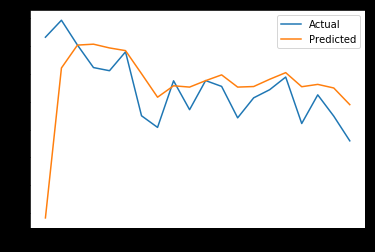

Here is a good example of the cause of the large spikes in the mse graph. You can see that the algorithim is predicting the trend of the stock market extremly well. The MSE error spike comes from the daily deviations that can occur in the market as well as the RNN picking up "steam". We will take this into account when making our grid search CV (e.g. log the loss at a bad point in the model, Compare the slopes MSE over the given time period).

# Neural Net Development
Here we will perform a Gird Search and save the results of each model into a dataframe.
We wil start with some intuition in its creation and implement a mutation algorithim to further advance the network architecture.

TO DO:
- [ ] Set a train/test split in the data
- [ ] set up a grid search w/ metrics ( e.g. early stopping to get simple curve?)
- [ ] fix chage_args style
- [ ] fix prediction stuff

In [145]:
class model_selector():
    def __init__(self, parameters):
        np.random.seed(parameters['numpy_seed'])
        self.grid_name = parameters['grid_name']
        self.root_logdir = parameters['root_logdir']
        
        self.symbol = parameters['symbol']
        self.value = parameters['_from']
        self.size_data = parameters['size_data']
        self.limit = parameters['limit']
        
        self.prediction_value = parameters['prediction_value']
        self.layer_type = parameters['layer_type']
        self.n_neurons = parameters['n_neurons']
        self.n_layers = parameters['n_layers']
        self.drop_out = parameters['drop_out']
        self.n_steps = parameters['n_steps']
        self.n_inputs = parameters['n_inputs']
        self.n_outputs = parameters['n_outputs']
        self.learning_rate = parameters['learning_rate']
        
        self.n_epochs = parameters['n_epochs'] 
        self.n_batches = parameters['n_batches']
        self.batch_size = parameters['batch_size']
        
        self.X_start = parameters['X_start']
        self.prediction_count = parameters['prediction_count']
        
        symbols = list(set(['+','-',0,1,2,3,4,5,6,7,8,9]))
        self.symbol_to_ix = { sym:i for i,sym in enumerate(symbols) }
        self.ix_to_symbol = { i:sym for i,sym in enumerate(symbols)}
        
        self.my_encoder = {}
        for t in range(0,12):
            self.my_encoder[t] = np.zeros((12, 1))
            self.my_encoder[t][t] = 1

    def adjust_args(self, parameters):
        self.symbol = parameters['symbol']
        self.value = parameters['_from']
        self.size_data = parameters['size_data']
        self.limit = parameters['limit']
        
        self.prediction_value = parameters['prediction_value']
        self.layer_type = parameters['layer_type']
        self.n_neurons = parameters['n_neurons']
        self.n_layers = parameters['n_layers']
        self.drop_out = parameters['drop_out']
        self.n_steps = parameters['n_steps']
        self.n_inputs = parameters['n_inputs']
        self.n_outputs = parameters['n_outputs']
        self.learning_rate = parameters['learning_rate']
        
        self.n_epochs = parameters['n_epochs'] 
        self.n_batches = parameters['n_batches']
        self.batch_size = parameters['batch_size']
        
        self.X_start = parameters['X_start']
        self.prediction_count = parameters['prediction_count']
        
        
    def fetch_data(self):
        print('fetching data by the', self.size_data,'from', self.value,'\n')
        self.df = api.polygon.historic_agg( 
                _from =self.value,size=self.size_data,                       
                symbol=self.symbol, limit=self.limit).df
        self.df.drop(columns=['volume'] )
        
        '''
        normalized_df=(df-df.mean())/df.std()
        self.df = normalized_df
        '''
        #self.ohlc_avg = self.df.mean(axis=1)
        #self.ohlc_avg = pd.DataFrame(self.ohlc_avg )
        #self.df = self.ohlc_avg
        self.df= self.df[['close']]
        scaler = MinMaxScaler()
        self.df_scaled = pd.DataFrame(scaler.fit_transform(self.df))
        
        
    
        self.df_train = self.df_scaled.sample(frac=0.8)
        self.df_test = self.df_scaled.drop(self.df_train.index)
        print(self.df_scaled.head())

  
    def fetch_batch(self, indicator):
        self.X_batch = []
        self.y_batch = []
        if indicator == 'train':
            for _ in range(self.n_batches):
                p = np.random.randint(len(self.df_train)-self.batch_size-1, size = 1)[0]
                self.X_batch.append([item for item in self.df_train.iloc[p:self.batch_size+p].values])
                self.y_batch.append([item for item in self.df_train.iloc[p+1:self.batch_size+p+1].values])
            return np.array(self.X_batch), np.array(self.y_batch)
        else:
            for _ in range(self.n_batches):
                p = np.random.randint(len(self.df_test)-self.batch_size-1, size = 1)[0]
                self.X_batch.append([item for item in self.df_test.iloc[p:self.batch_size+p].values])
                self.y_batch.append([item for item in self.df_test.iloc[p+1:self.batch_size+p+1].values])
            return np.array(self.X_batch), np.array(self.y_batch)
        
    def analyze(self, indicator):
        with tf.Session() as sess:
            self.saver.restore(sess, "./my_model.ckpt")
            self.X_new , _ = self.fetch_batch(indicator)
            self.y_pred = sess.run(self.outputs, feed_dict = {self.X:self.X_new})
            
        self.new_df = pd.DataFrame( [self.X_new[0].ravel(), self.y_pred[0].ravel()]).T.rename(columns={0:'Actual', 1:'Predicted'})
        self.new_df.plot()
        
    def predict(self):
        X_start_local = self.X_start
        with tf.Session() as sess:
            self.saver.restore(sess, "./my_model.ckpt")
            for _ in range(0, self.prediction_count):
                y_pred = sess.run(self.outputs, feed_dict = {self.X:[np.array(X_start_local)]})
                self.states_return = sess.run(self.states, feed_dict = {self.X:[np.array(X_start_local)]})
                X_start_local.append(y_pred[0][_])
            return X_start_local, self.states_return
        

    def build_model(self):

        he_init = tf.keras.initializers.glorot_uniform(seed=None)
        tf.reset_default_graph()
        
        with tf.name_scope('inputs'):
            self.X = tf.placeholder(tf.float32, [None, None, self.n_inputs])
            self.y = tf.placeholder(tf.float32, [None, None, self.n_outputs])

        with tf.name_scope('cells'):
            if self.layer_type == 'LSTM':
                self.cells = [tf.nn.rnn_cell.LSTMCell(num_units=self.n_neurons[_], activation=tf.nn.leaky_relu) for _ in range(self.n_layers)]
            elif self.layer_type == 'GRU':
                self.cells = [tf.nn.rnn_cell.GRUCell(num_units=self.n_neurons[_], activation=tf.nn.leaky_relu) for _ in range(self.n_layers)]
            else:
                self.cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=self.n_neurons[_], activation=tf.nn.leaky_relu) for _ in range(self.n_layers)]
            if self.drop_out >0:
                self.cells_drop = [tf.nn.rnn_cell.DropoutWrapper(cell, input_keep_prob=self.drop_out) for cell in self.cells]
                self.multi_cell = tf.contrib.rnn.MultiRNNCell(self.cells_drop)
            else:
                self.multi_cell = tf.contrib.rnn.MultiRNNCell(self.cells)
            self.output, self.states = tf.nn.dynamic_rnn(self.multi_cell, self.X, dtype=tf.float32)
            

        with tf.name_scope('outputs'):
            self.outputs = tf.layers.dense(self.output, self.n_outputs,
                                        name='dense', activation = tf.nn.leaky_relu, 
                                        kernel_initializer = he_init)

        with tf.name_scope('accuracy/evaluation'):
            accuracy = tf.reduce_mean(tf.square(self.outputs - self.y))
        '''   
        with tf.name_scope('learning_rate_decay'):
            self.global_step = tf.Variable(0, trainable=False)
            self.inc_gstep = tf.assign(self.global_step, self.global_step + 1)
            self.tf_learning_rate = tf.placeholder(tf.float32, None)
            self.tf_min_learning_rate = tf.placeholder(tf.float32, None)
            self.learning_rate_decay = tf.maximum(tf.train.exponential_decay(self.learning_rate, self.global_step, decay_steps=1, decay_rate=0.5, staircase = True), self.tf_min_learning_rate)
        '''    
        with tf.name_scope('training'):
            self.loss = tf.reduce_mean(tf.square(self.outputs - self.y))
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.train_op = self.optimizer.minimize(self.loss)

        print('Graph Shape')
        print('X:', self.X.shape)
        print('y:', self.y.shape)
        print('LSTM states:', self.states[-1][1].shape)
        print('LSTM output:', self.output.shape)
        print('outputs:', self.outputs.shape)
        
    def train(self):
        self.saver = tf.train.Saver()
        init = tf.global_variables_initializer()
        
        
        now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
        self.logdir = "{}/run-{}/".format(self.root_logdir, now)
        self.file_write = tf.summary.FileWriter(self.logdir, tf.get_default_graph())

        self.mse_summary = tf.summary.scalar('mse', self.loss)
        self.mse_valid_summary = tf.summary.scalar('mse_valid', self.loss)
        self.predicted_value = tf.summary.scalar('predicted_value', self.outputs)
        self.actual_value = tf.summary.scalar('actual_value', self.X)
        
        self.training_graphs = []

        with tf.Session() as sess:
            '''
            implement resume logic here?
            self.saver.restore(sess, "./my_model.ckpt")
            '''
            init.run()
            print('running')
            for epoch in range(self.n_epochs):
                self.X_batch, self.y_batch = self.fetch_batch('train')
                self.X_valid, self.y_valid = self.fetch_batch('test')
                sess.run(self.train_op, feed_dict = {self.X: self.X_batch, self.y:self.y_batch})
                
                if epoch %1000 == 0:
                    print('\n epoch:',epoch)
                    print('MSE train:', self.loss.eval(feed_dict={self.X:self.X_batch, self.y:self.y_batch}))
                    print('MSE validate: ', self.loss.eval(feed_dict={self.X:self.X_valid, self.y:self.y_valid}))
                    file_path_2 = "./my_model.ckpt"
                    save_path = self.saver.save(sess, file_path_2)

                if epoch %10 == 0:
                    self.summary_str = self.mse_summary.eval(feed_dict={self.X: self.X_batch, self.y: self.y_batch})
                    self.summary_str2 = self.mse_valid_summary.eval(feed_dict={self.X: self.X_batch, self.y: self.y_batch})
                    step = epoch
                    self.file_write.add_summary(self.summary_str, step)   
                    self.file_write.add_summary(self.summary_str2, step)
                    
                if epoch % 500 ==0:
                    self.y_pred = self.outputs.eval(feed_dict={self.X:self.X_valid})
                    self.training_graphs.append(pd.DataFrame( [self.X_valid[0].ravel(), self.y_pred[0].ravel()]).T.rename(columns={0:'Actual', 1:'Predicted'}))




In [146]:
model = model_selector({
                        #Setup Args:
                        'numpy_seed': 8,
                        'grid_name':'test',
                        'root_logdir':'C:/Users/Kyle/tf_logs/my_logs/',
    
                        #Training Data Args:
                        'symbol': 'ROKU',
                        '_from' : '2010-01-01 00:00:00-04:00',
                        'size_data': 'day',
                        'limit': 60000, 
    
                        #Graph Args:
                        'prediction_value':'close',
                        'layer_type':'LSTM',
                        'n_neurons': [200,200,200],
                        'n_layers':3,
                        'drop_out':0,
                        'n_steps': 100,
                        'n_inputs':1,
                        'n_outputs':1,
                        'learning_rate':0.0001,
    
                        #Training Args:
                        'n_epochs' : 10000,
                        'n_batches' : 500,
                        'batch_size' : 50,
    
                        #Prediction Args:
                        'X_start':[[1.03],[1.04]],
                        'prediction_count': 50,
                        
})

In [147]:
model.fetch_data()
model.build_model()

fetching data by the day from 2010-01-01 00:00:00-04:00 

          0
0  0.085132
1  0.137627
2  0.086168
3  0.038681
4  0.039371
Graph Shape
X: (?, ?, 1)
y: (?, ?, 1)
LSTM states: (?, 200)
LSTM output: (?, ?, 200)
outputs: (?, ?, 1)


In [148]:
model.train()

running

 epoch: 0
MSE train: 0.24148211
MSE validate:  0.24148211

 epoch: 1000
MSE train: 0.00572744
MSE validate:  0.00572744

 epoch: 2000
MSE train: 0.0028076568
MSE validate:  0.0028076568


KeyboardInterrupt: 

INFO:tensorflow:Restoring parameters from ./my_model.ckpt
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
INFO:tensorflow:Restoring parameters from ./my_model.ckpt
INFO:tensorflow:Restoring parameters from ./my_model.ckpt


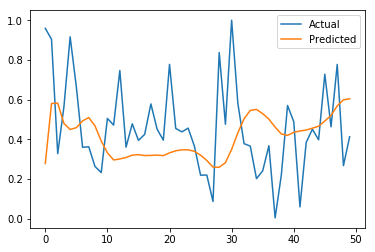

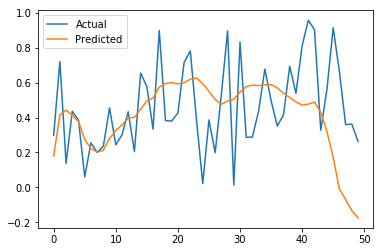

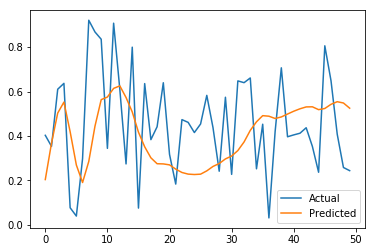

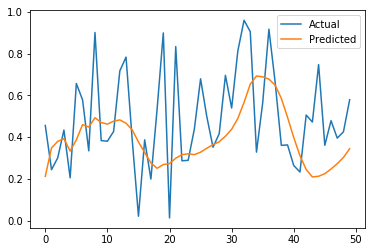

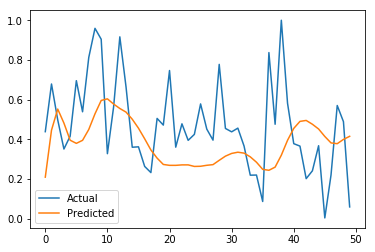

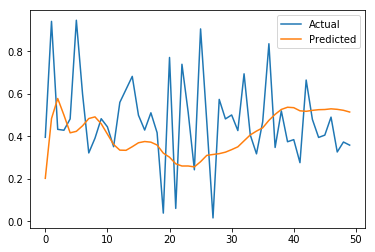

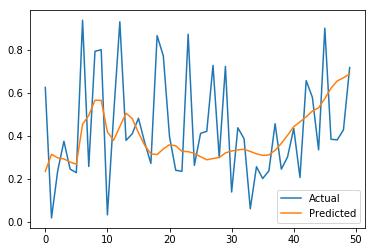

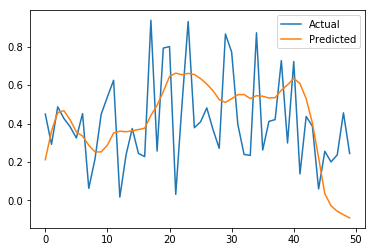

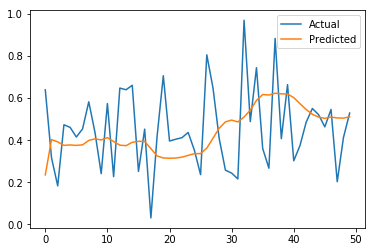

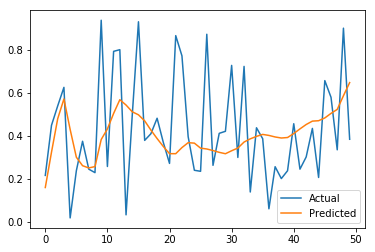

In [154]:
for _ in range(10):
    model.analyze('train')

In [157]:
X_batch_start, _ = model.fetch_batch('test')
model.adjust_args({
                        #Setup Args:
                        'numpy_seed': 8,
                        'grid_name':'test',
                        'root_logdir':'C:/Users/Kyle/tf_logs/my_logs/',
    
                        #Training Data Args:
                        'symbol': 'AAPL',
                        '_from' : '2011-01-01 00:00:00-04:00',
                        'size_data': 'day',
                        'limit': 60000, 
    
                        #Graph Args:
                        'prediction_value':'close',
                        'layer_type':'LSTM',
                        'n_neurons': [200,200,150],
                        'n_layers':3,
                        'drop_out':0.2,
                        'n_steps': 100,
                        'n_inputs':1,
                        'n_outputs':1,
                        'learning_rate':0.0001,
    
                        #Training Args:
                        'n_epochs' : 10000,
                        'n_batches' : 500,
                        'batch_size' : 50,
    
                        #Prediction Args:
                        'X_start':list(X_batch_start[0][0:18]),
                        'prediction_count': 31,
                        
})

INFO:tensorflow:Restoring parameters from ./my_model.ckpt


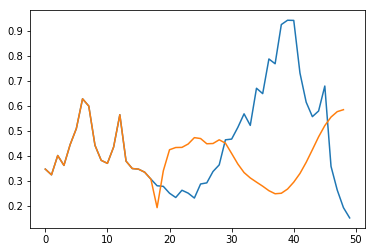

In [158]:
predicted, states = model.predict()
plt.plot(X_batch_start[0])
plt.plot(predicted)

In [7]:
recent_prices = api.polygon.historic_agg( _from ='2019-02-22 00:00:00-04:00',size="day" ,symbol='CELG', limit=None).df

In [19]:
recent_prices
recent_prices = recent_prices.drop(columns=['volume'] )

In [20]:

recent_prices_ohlc_avg = recent_prices.mean(axis=1)
recent_prices_ohlc_avg = pd.DataFrame(recent_prices_ohlc_avg )

In [21]:
recent_prices_ohlc_avg

,0
day,
2019-02-21 00:00:00-05:00,89.33250
2019-02-22 00:00:00-05:00,89.16250
2019-02-25 00:00:00-05:00,89.94000
2019-02-26 00:00:00-05:00,89.99250
2019-02-27 00:00:00-05:00,90.33750
2019-02-28 00:00:00-05:00,84.09000
2019-03-01 00:00:00-05:00,84.99500
2019-03-04 00:00:00-05:00,85.78000
2019-03-05 00:00:00-05:00,85.95500


In [22]:

X_batch_start = np.array([item for item in recent_prices_ohlc_avg.iloc[0:18].values])

In [23]:
list(X_batch_start[0:18])

[array([89.3325]),
 array([89.1625]),
 array([89.94]),
 array([89.9925]),
 array([90.3375]),
 array([84.09]),
 array([84.995]),
 array([85.78]),
 array([85.955]),
 array([86.295]),
 array([86.2]),
 array([84.8225]),
 array([85.0525]),
 array([85.6725]),
 array([86.5675]),
 array([88.065]),
 array([88.46875]),
 array([88.165])]

In [24]:
model.adjust_args({
                        #Setup Args:
                        'numpy_seed': 8,
                        'grid_name':'test',
                        'root_logdir':'C:/Users/Kyle/tf_logs/my_logs/',
    
                        #Training Data Args:
                        'symbol': 'AAPL',
                        '_from' : '2011-01-01 00:00:00-04:00',
                        'size_data': 'day',
                        'limit': 60000, 
    
                        #Graph Args:
                        'prediction_value':'close',
                        'layer_type':'LSTM',
                        'n_neurons': [200,200,150],
                        'n_layers':3,
                        'drop_out':0.2,
                        'n_steps': 100,
                        'n_inputs':1,
                        'n_outputs':1,
                        'learning_rate':0.0001,
    
                        #Training Args:
                        'n_epochs' : 10000,
                        'n_batches' : 500,
                        'batch_size' : 50,
    
                        #Prediction Args:
                        'X_start':list(X_batch_start[0:18]),
                        'prediction_count': 31,
                        
})
predicted, states = model.predict()
plt.plot(X_batch_start[0:18])
#plt.plot(predicted)

NameError: name 'model' is not defined

# Junk Code

In [ ]:
grid_search_parameters = {
                        #Setup Args:
                        'grid_name':'test1',
                        'root_logdir':'C:/Users/Kyle/tf_logs/my_logs/',
    
                        #Training Data Args:
                        'symbol': 'AAPL',
                        '_from' : '2011-01-01 00:00:00-04:00',
                        'size_data': 'day',
                        'limit': 10000, 
    
                        #Graph Args:
                        'prediction_value':'close',
                        'layer_type':'LSTM',
                        'n_neurons': 100,
                        'n_layers':3,
                        'n_steps': 14,
                        'n_inputs':1,
                        'n_outputs':1,
                        'learning_rate':0.001,
    
                        #Training Args:
                        'n_epochs' : 10000,
                        'n_batches' : 80,
                        'batch_size' : 14,
                        

}
keys, values = zip(*grid_search_parameters.items())
experiments = [dict(zip(keys, values)) for values in itertools.product(*values)]

In [179]:
symbols = list(set(['+','-',0,1,2,3,4,5,6,7,8,9]))
symbol_to_ix = { sym:i for i,sym in enumerate(symbols) }
ix_to_symbol = { i:sym for i,sym in enumerate(symbols)}

In [180]:
print(symbol_to_ix, ix_to_symbol)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, '-': 10, '+': 11} {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: '-', 11: '+'}


In [235]:
str([[x] for x in df['close'][1][0]])

IndexError: invalid index to scalar variable.

In [3]:
n_batches = 1
prediction_value = 'close'
batch_size = 4
def fetch_batch_for_logits():
    X_batch = []
    y_batch = []
    
    for _ in range(n_batches):
        p = np.random.randint(len(df)-batch_size-1, size = 1)[0]
        for sym in df.iloc[p:batch_size+p][prediction_value]:
            print(list(str(sym)))
            #list = [[x] for x in str(sym).split()]
            #print(list)
                
        X_batch.append([my_encoder[symbol_to_ix[symbol_to_ix[]].ravel() for sym in  df.iloc[p:batch_size+p][prediction_value]])
            #self.X_batch.append([[item] for item in self.df.iloc[p:self.batch_size+p][self.prediction_value]])
            #Here we will append the X+1 value for each value X
            #self.y_batch.append([[item] for item in self.df.iloc[p+1:self.batch_size+p+1][self.prediction_value]])
        #Y_batch.append([symbol_to_ix[sym] for sym in df.iloc[p+1:batch_size+p+1][prediction_value]])
    #return np.array(self.X_batch), np.array(self.y_batch)

SyntaxError: invalid syntax (<ipython-input-3-0732ff36c41c>, line 15)

In [275]:
fetch_batch_for_logits()
list(str('12890374'))

['0', '.', '0', '0', '8', '2', '7', '1', '2', '6', '0', '3', '0', '7', '4', '5', '4', '4', '4', '1']
['-', '0', '.', '0', '1', '0', '3', '1', '1', '6', '3', '4', '0', '5', '2', '5', '3', '5', '5', '6']
['-', '0', '.', '0', '0', '2', '8', '7', '8', '4', '7', '6', '3', '0', '8', '5', '3', '9', '7', '4', '6']
['-', '0', '.', '0', '2', '0', '8', '0', '5', '5', '0', '3', '8', '0', '8', '7', '6', '5', '3', '6', '3']


['1', '2', '8', '9', '0', '3', '7', '4']

In [181]:
my_encoder = {}
for t in range(0,12):
    my_encoder[t] = np.zeros((12, 1))
    my_encoder[t][t] = 1
my_encoder[11].ravel()

In [181]:
'''  
    def build_model_with_logits(self):

        he_init = tf.keras.initializers.glorot_uniform(seed=None)
        tf.reset_default_graph()
        
        with tf.name_scope('inputs'):
            self.X = tf.placeholder(tf.float32, [None, None, self.n_inputs])
            self.y = tf.placeholder(tf.float32, [None, None, self.n_outputs])

        with tf.name_scope('cells'):
            if self.layer_type == 'LSTM':
                self.cells = [tf.nn.rnn_cell.LSTMCell(num_units=self.n_neurons, activation=tf.nn.leaky_relu) for _ in range(self.n_layers)]
            elif self.layer_type == 'GRU':
                self.cells = [tf.nn.rnn_cell.GRUCell(num_units=self.n_neurons, activation=tf.nn.leaky_relu) for _ in range(self.n_layers)]
            else:
                self.cells = [tf.nn.rnn_cell.BasicRNNCell(num_units=self.n_neurons, activation=tf.nn.leaky_relu) for _ in range(self.n_layers)]
            self.multi_cell = tf.contrib.rnn.MultiRNNCell(self.cells)
            self.outputs, self.states = tf.nn.dynamic_rnn(self.multi_cell, self.X, dtype=tf.float32)

        with tf.name_scope('outputs'):
            self.logits = tf.layers.dense(self.outputs, self.n_outputs,
                                        name='dense', activation = tf.nn.leaky_relu, 
                                        kernel_initializer = he_init)

        with tf.name_scope('accuracy/evaluation'):
            print('none')
            self.output = tf.argmax(logits, axis=2, name='output')
            self.prediction = tf.nn.softmax(logits)
            self.accuracy = tf.reduce_mean(tf.square(self.outputs - self.y))
            self.correct_pred = tf.equal(self.output[self.n_batches-1], self.y[self.n_batches-1])
            self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))

        with tf.name_scope('training'):
            self.xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=self.y, name='loss')
            self.loss = tf.reduce_mean(self.xentropy)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
            self.train_op = optimizer.minimize(self.loss)
            

        print('Graph Shape')
        print('X:', self.X.shape)
        print('y:', self.y.shape)
        print('LSTM states:', self.states[-1][1].shape)
        print('LSTM output:', self.output.shape)
        print('logits:', self.logits.shape)

        print('outputs:', self.outputs.shape)
'''
'''        
    def fetch_batch_for_logits(self):
        self.X_batch = []
        self.y_batch = []
        for _ in range(self.n_batches):
            p = np.random.randint(len(self.df)-self.batch_size-1, size = 1)[0]
                [[x] for x in self.df.iloc[p:self.batch_size+p][self.prediction_value]]
            self.X_batch.append([self.my_encoder[symbol_to_ix[[[x] for x in str(sym)[0]]]].ravel() for  in  self.df.iloc[p:self.batch_size+p][self.prediction_value]])
            #self.X_batch.append([[item] for item in self.df.iloc[p:self.batch_size+p][self.prediction_value]])
            #Here we will append the X+1 value for each value X
            #self.y_batch.append([[item] for item in self.df.iloc[p+1:self.batch_size+p+1][self.prediction_value]])
            self.Y_batch.append([symbol_to_ix[sym] for sym in self.df.iloc[p+1:self.batch_size+p+1][self.prediction_value]])
        return np.array(self.X_batch), np.array(self.y_batch)
'''  

'        \n    def fetch_batch_for_logits(self):\n        self.X_batch = []\n        self.y_batch = []\n        for _ in range(self.n_batches):\n            p = np.random.randint(len(self.df)-self.batch_size-1, size = 1)[0]\n                [[x] for x in self.df.iloc[p:self.batch_size+p][self.prediction_value]]\n            self.X_batch.append([self.my_encoder[symbol_to_ix[[[x] for x in str(sym)[0]]]].ravel() for  in  self.df.iloc[p:self.batch_size+p][self.prediction_value]])\n            #self.X_batch.append([[item] for item in self.df.iloc[p:self.batch_size+p][self.prediction_value]])\n            #Here we will append the X+1 value for each value X\n            #self.y_batch.append([[item] for item in self.df.iloc[p+1:self.batch_size+p+1][self.prediction_value]])\n            self.Y_batch.append([symbol_to_ix[sym] for sym in self.df.iloc[p+1:self.batch_size+p+1][self.prediction_value]])\n        return np.array(self.X_batch), np.array(self.y_batch)\n'